In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'power_production_wind_avg')

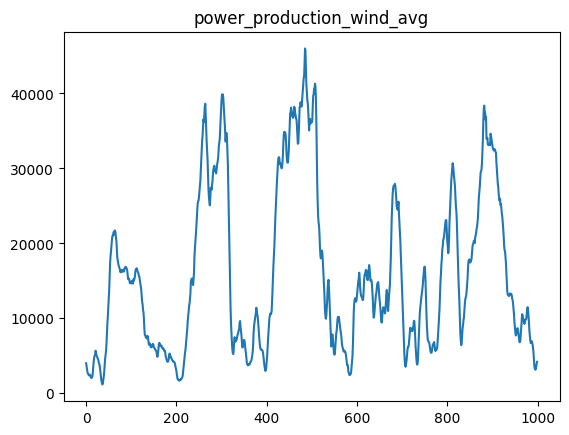

In [20]:
df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
df = df[["datetime","power_production_wind_avg"]]
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

y = df["power_production_wind_avg"]
t = range(y.size)
plt.plot(y[0:1000])
plt.title("power_production_wind_avg")


In [3]:
# df.dtypes
# # change column type to DateTime
# # df['datetime'] = pd.to_datetime(df['datetime'])
# date_cols = df.columns[0:4]
# df[date_cols] = df[date_cols].apply(pd.to_datetime)
# df.dtypes
# df.head()

In [4]:
for i in range(df.shape[1]):
    print(f"{df.columns.values[i]}: {df.dtypes[i]}")

datetime: datetime64[ns, UTC]
power_production_wind_avg: float64


In [5]:
print(df.shape)

(8760, 2)


In [6]:
# from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution
# from wetterdienst import Wetterdienst, Resolution, Period

# API = Wetterdienst(provider="dwd", network="observation")

# stations = DwdObservationRequest(
#     parameter=DwdObservationDataset.CLOUDINESS,
#     resolution=Resolution.DAILY,
#     start_date="2021-01-01",
#     end_date="2021-01-05"
# )
# print(next(stations.all().values.query()))

# Wetterdienst.discover()

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [11]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)

# how many "x" inputs to provide in the RNN
past_history = 300

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 100

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y and y, since we're only going to predict a single feature (power production wind) at first 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(y, y, 0, testsplit, 
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single   = multivariate_data(y, y, testsplit, None, 
                                                   past_history, future_target, step,
                                                   single_step=False)

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature
x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single  = x_test_single.reshape( *x_test_single.shape, 1)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_single.shape, y_train_single.shape)
print("shapes of x_test and y_test: ", x_test_single.shape, y_test_single.shape)

# print a few values
print("")
print(x_train_single[:3,:3])

print()
print("x_train[300]: ", *x_train_single[300][:3], "...")
print("y_train[0] :  ", y_train_single[0][:3], "...")

0    4006.75
1    3573.75
2    3145.25
3    2828.50
4    2608.75
Name: power_production_wind_avg, dtype: float64
7008
shape of y: (8760,)
shapes of x_train and y_train:  (6708, 300, 1) (6708, 100)
shapes of x_test and y_test:  (1352, 300, 1) (1352, 100)

[[[4006.75]
  [3573.75]
  [3145.25]]

 [[3573.75]
  [3145.25]
  [2828.5 ]]

 [[3145.25]
  [2828.5 ]
  [2608.75]]]

x_train[300]:  [39102.25] [39878.75] [39597.5] ...
y_train[0] :   [39102.25 39878.75 39597.5 ] ...


In [10]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
# YOUR CODE HERE
single_feature_model = Sequential()
single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
single_feature_model.add(Dense(future_target, activation='selu'))

# raise NotImplementedError()

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
# YOUR CODE HERE
single_feature_model.compile(optimizer="adam", loss="mse", metrics=r2_score)
#raise NotImplementedError()

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
Total params: 79,460
Trainable params: 79,460
Non-trainable params: 0
_________________________________________________________________


In [12]:
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=5, validation_split=0.25)

Epoch 1/5
158/158 [==============================] - 29s 173ms/step - loss: 246025824.0000 - r2_score: -1.6437 - val_loss: 222438880.0000 - val_r2_score: -5.1863
Epoch 2/5
158/158 [==============================] - 25s 159ms/step - loss: 245568256.0000 - r2_score: -1.6262 - val_loss: 222026144.0000 - val_r2_score: -5.1687
Epoch 3/5
158/158 [==============================] - 28s 176ms/step - loss: 245141536.0000 - r2_score: -1.6227 - val_loss: 221593712.0000 - val_r2_score: -5.1503
Epoch 4/5
158/158 [==============================] - 24s 154ms/step - loss: 244680688.0000 - r2_score: -1.6235 - val_loss: 221152256.0000 - val_r2_score: -5.1314
Epoch 5/5
158/158 [==============================] - 24s 152ms/step - loss: 244221136.0000 - r2_score: -1.6163 - val_loss: 220720640.0000 - val_r2_score: -5.1130


dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


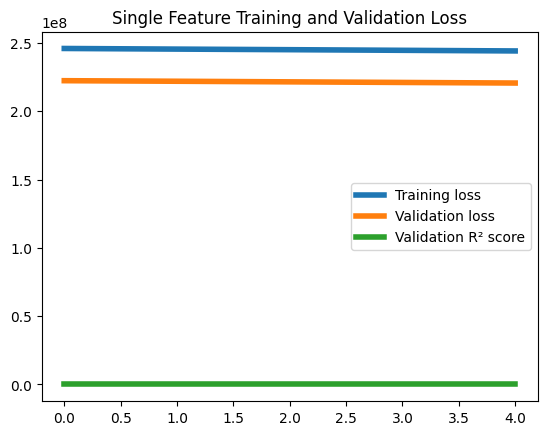

In [14]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')